<a href="https://colab.research.google.com/github/abhilasha-kumar/modeling-lexical-retrieval/blob/main/LexicalRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Allow drive access

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# GPU access

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Fri May  6 17:02:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    56W / 149W |    145MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import heapq
import itertools
import scipy.spatial.distance

import pandas as pd
import numpy as np

from numpy.random import randint
from scipy.special import softmax
from sklearn.preprocessing import MinMaxScaler, normalize
from numpy.linalg import matrix_power
from functools import lru_cache
import glob
from scipy.special import expit
from scipy import stats

import matplotlib.pyplot as plt
import nltk
from functools import lru_cache
from itertools import product as iterprod
import itertools
from nltk.metrics import *
import re
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Importing Data

We read in the experimental data and vocabulary words.

In [ ]:
with tf.device('/device:GPU:0'):
  julie_files = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/Julie_2021data.csv", encoding= 'unicode_escape')
  orig_vocab = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/julie_vocab.csv")
  vocab_plus = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/full_vocab.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Import USE

The Universal Sentence Encoder uses two different architctures to encode a string of any length into a compact high-dimensional vector representation -- the Deep Averaging Network (which is more of a bag-of-words approach) and the Transformer network (more predictive, attention-based).  

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
dan_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
#transformer_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" 
model = hub.load(dan_url)
print ("module %s loaded" % dan_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
# cosine similarity function
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

# Create phoneme function

Here we create a function that takes any letter string and partitions it into phonemes based on arpabet. Then we compute a measure of "normalized" phonemic similarity

In [ ]:
# algo to obtain phonemes for any given strng
# obtained from: https://stackoverflow.com/questions/33666557/get-phonemes-from-any-word-in-python-nltk-or-other-modules
try:
    arpabet = nltk.corpus.cmudict.dict()
except LookupError:
    nltk.download('cmudict')
    arpabet = nltk.corpus.cmudict.dict()

@lru_cache()
def wordbreak(s):
    s = s.lower()
    if s in arpabet:
        return arpabet[s]
    middle = len(s)/2
    partition = sorted(list(range(len(s))), key=lambda x: (x-middle)**2-x)
    for i in partition:
        pre, suf = (s[:i], s[i:])
        if pre in arpabet and wordbreak(suf) is not None:
            return [x+y for x,y in iterprod(arpabet[pre], wordbreak(suf))]
    return None

def normalized_sim(w1, w2):
  return 1-edit_distance(w1,w2)/(max(len(w1), len(w2)))

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


# preparing/reducing data size

Creating reduced data set with only unique prompts and primes

In [ ]:
## preparing data
julie_files["ActualPrime"] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()
print(f"full dataset is {len(julie_files)} rows")
## for target accuracy we only need 100 (prompts) x 4 (primes)
targetacc_data = julie_files[["ActualPrime", "PrimeCondition", "Target", "prompt"]].drop_duplicates()

print(f"target accuracy data is {len(targetacc_data)} rows")


full dataset is 17400 rows
target accuracy data is 400 rows
response accuracy data is 4216 rows


# Computing all vectors

Only necessary to complete once, or can otherwise move to the next cell and read in the already computed vectors

In [ ]:
# pre-computing all vectors for prompts and vocabulary words 
# takes in dataframe containing prompts, creates dataframes of prompt and vocab vectors, exports them to Drive
def vectors(data):
  prompts = pd.Series(data["prompt"].unique())
  p_vecs = np.array([model([x])[0].numpy() for x in prompts])
  print(p_vecs.shape)

  p_vectors_df = pd.DataFrame(p_vecs).transpose()
  print(p_vectors_df.shape)
  p_vectors_df.columns = prompts
  print(p_vectors_df.head())
  p_vectors_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/PromptVectors_New.csv", index = False)

  words = list(orig_vocab.vocab_word) + list(vocab_plus.vocab_word[12618:]) # original vocab list + all added words from responses
  w_vecs = np.array([model([x])[0].numpy() for x in words])
  print(w_vecs.shape)
  w_vectors_df = pd.DataFrame(w_vecs).transpose()

  print(w_vectors_df.shape)
  w_vectors_df.columns = words
  print(w_vectors_df.head())
  w_vectors_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/VocabVectors_New.csv", index = False)

vectors(targetacc_data)


(100, 512)
(512, 100)
   To refrain deliberately and often with an effort of self-denial from an action or practice  ...  Happening by a lucky chance or by accident rather than by design
0                                           0.014262                                           ...                                          -0.002915               
1                                           0.018321                                           ...                                          -0.052756               
2                                           0.026393                                           ...                                          -0.002790               
3                                          -0.029389                                           ...                                           0.019612               
4                                           0.018353                                           ...                                           0.037026    

In [ ]:
# read and store precomputed vectors, verify that they have the expected dimensions
prompt_vectors = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/PromptVectors_New.csv")
print(prompt_vectors.shape)
vocab_vectors = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/VocabVectors_New.csv")
print(vocab_vectors.shape)

(512, 100)
(512, 13693)


In [ ]:
# each prompt/vocabulary word is represented by a 512-dimensional vector
prompt_vectors['Capital of South Korea']

0      0.018930
1     -0.011326
2      0.000773
3      0.041382
4     -0.006024
         ...   
507   -0.052603
508    0.031974
509   -0.059387
510   -0.077468
511   -0.072401
Name: Capital of South Korea, Length: 512, dtype: float64

# Model functions

In [ ]:
def initial_activation(vocab_words):
  # returns an array of initial activations, currently zero, but eventually replace by word frequency
  x = np.zeros((len(vocab_words),1)).T
  return x

In [ ]:
def activate_prompt_neighbors(activations, prompt, noise_level):
  ## takes in a 1-d array of current activations
  ## computes a vector representation of the prompt and returns a vector of similarities to each word in vocab + activations
  ## with some noise added to each estimate
  noise = np.random.normal(0, noise_level, 1)
  prompt_vec = prompt_vectors[prompt].values
  resp = vocab_vectors.columns
  cosine_list = np.array([cosine(prompt_vec, vocab_vectors[r].values) for r in resp]) + activations # eventually add noise
  return cosine_list


In [ ]:
def activate_prime_neighbors(prime):
  ## returns "primed" activations for both semantic and phonological 
  prime_vec = vocab_vectors[prime].values
  resp = vocab_vectors.columns
  semantic = np.array([cosine(prime_vec, vocab_vectors[r].values) for r in resp]) 
  phon = np.array([normalized_sim(r, prime) for r in resp]).reshape(semantic.shape)
  assert semantic.shape == phon.shape
  return semantic, phon


In [ ]:
def combine_semantic_phonological(prompt_act, semantic, phonological, theta=0): 
  # takes in activation arrays for prompt, prime-semantic, and prime phonological and combine with specified operation
  # returns softmax of combined activations
  if theta <= 1:
    wtds = theta * semantic
    wtdp = (1-theta)*phonological
    comb = np.add(wtds, wtdp) + prompt_act
  else:
    comb = np.multiply(semantic, phonological) + prompt_act
  return softmax(comb)


# Calculating Likelihoods


(skip to the last cell of this section to read in precomputed negative log-likelihoods)

In [ ]:
# calculates and stores likelihoods of response and target words for each model

theta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]
# clean data
julie_files['ActualPrime'] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()

# dictionaries to be turned into dataframes
resp_ll = {'prompt':[], 'prime':[], 'resp':[], 'modelType':[], 'theta':[], 'likelihood':[], 'NLL':[]}
targ_ll = {'prompt':[], 'prime':[], 'targ':[], 'modelType':[], 'theta':[], 'likelihood':[], 'NLL': []}
# dictionaries to save prompt and prime activations to avoid running the same calculations more than once
prompt_acts = {}
prime_acts = {}
# counting number of responses/targets excluded from the dataframes (non-responses and words not in the vocabulary)
noresp = 0
notinvocab = 0
tomit = 0

# for any trial of data, run each model, and record the likelihoods of the response/target in the above dictionaries
# takes in a row (trial) from the data, whether to analyze the response or target, and list of theta values representing each model 
def get_likelihoods(row, rort, theta):
  word = row['Resp'] if rort == 'r' else row['Target'] # focus on response or target
  dct = resp_ll if rort == 'r' else targ_ll # specifies dictionary in which to save results 

  # check whether prompt activations have already been saved; if not, create them
  if row["prompt"] not in prompt_acts: 
    init = initial_activation(list(orig_vocab.vocab_word) + list(vocab_plus.vocab_word[12618:])) # initial activation
    prompt_neighbors = activate_prompt_neighbors(init, row["prompt"], 0.1) # activate prompt's neighbors
    prompt_acts[row["prompt"]] = prompt_neighbors # save activations
  else:
    prompt_neighbors = prompt_acts[row["prompt"]] # retrieve saved activations

  i = vocab_vectors.columns.get_loc(word) # get the index of the word in activations lists

  # run each model
  for x in theta:
    # prompt only
    if x==1.2:
      final = softmax(prompt_neighbors)
      mt = 'none'

    # include primes
    else:
      mt = 'mult' if x==1.1 else 'add'

      # check whether prime activations have already been saved; if not, create them
      if row["ActualPrime"] not in prime_acts:
        a, b = activate_prime_neighbors(row["ActualPrime"]) # activate prompt's neighbors
        prime_acts[row["ActualPrime"]] = (a, b) # save activations
      else:
        a, b = prime_acts[row["ActualPrime"]] # retrieve saved activations
      final = combine_semantic_phonological(prompt_neighbors, a, b, x) # combine prompt activations, semantic & phonological prime activations

    # add results to dictionary
    dct['prompt'].append(row['prompt'])
    dct['prime'].append(row['ActualPrime'])
    dct['resp'].append(row['Resp']) if rort=='r' else dct['targ'].append(row['Target'])
    dct['modelType'].append(mt)
    dct['theta'].append(x)
    dct['likelihood'].append(final[0][i])

# go through each row of data
for index, row in julie_files.iterrows():
  # no response
  if row['Resp'] == '12345':
    noresp += 1
  # response not in vocabulary
  elif row['Resp'] not in vocab_vectors.columns:
    notinvocab += 1
  # otherwise, get response likelihood
  else:
    get_likelihoods(row, 'r', theta)
  
  # target not in vocabulary
  if row['Target'] not in vocab_vectors.columns:
    tomit += 1
  # otherwise, get target likelihood
  else:
    get_likelihoods(row, 't', theta)
  
  if index % 1000 == 0:
    print("Completed row", index)
    

  

Completed row 0
Completed row 100
Completed row 200
Completed row 300
Completed row 400
Completed row 500
Completed row 600
Completed row 700
Completed row 800
Completed row 900
Completed row 1000
Completed row 1100
Completed row 1200
Completed row 1300
Completed row 1400
Completed row 1500
Completed row 1600
Completed row 1700
Completed row 1800
Completed row 1900
Completed row 2000
Completed row 2100
Completed row 2200
Completed row 2300
Completed row 2400
Completed row 2500
Completed row 2600
Completed row 2700
Completed row 2800
Completed row 2900
Completed row 3000
Completed row 3100
Completed row 3200
Completed row 3300
Completed row 3400
Completed row 3500
Completed row 3600
Completed row 3700
Completed row 3800
Completed row 3900
Completed row 4000
Completed row 4100
Completed row 4200
Completed row 4300
Completed row 4400
Completed row 4500
Completed row 4600
Completed row 4700
Completed row 4800
Completed row 4900
Completed row 5000
Completed row 5100
Completed row 5200
Compl

In [ ]:
# calculate negative log-likelihoods
resp_ll['NLL'] = -1 * np.log(resp_ll['likelihood'])
targ_ll['NLL'] = -1 * np.log(targ_ll['likelihood'])


In [ ]:
# create dataframes
respLLdf = pd.DataFrame.from_dict(resp_ll)
targLLdf = pd.DataFrame.from_dict(targ_ll)
print(len(julie_files))
print("No response:", noresp)
print("Response not in vocab:", notinvocab)
print(len(respLLdf))

17400
No response: 7537
Response not in vocab: 14
128037


In [ ]:
# verify length of data
(17400 - (7537 + 14)) * 13

128037

In [ ]:
# number of responses included
17400 - (7537 + 14)

9849

In [ ]:
# write dataframes to csv files
respLLdf.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLogLikelihoods.csv")
targLLdf.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/TargetLogLikelihoods.csv")

In [ ]:
# read dataframes to csv files
respLLdf = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLogLikelihoods.csv")
targLLdf = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/TargetLogLikelihoods.csv")

# Overall model performance

In [ ]:
# group by model, sum negative log-likelihoods
rgroup = respLLdf[['theta', 'NLL']].groupby(['theta']).sum()

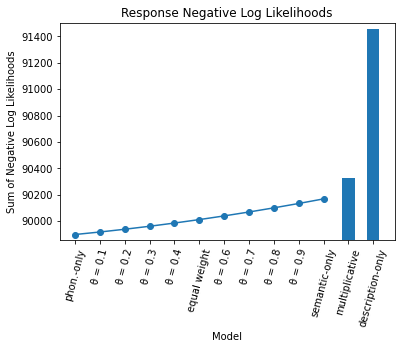

In [ ]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = rgroup['NLL'] 

# x-axis tick labels
values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o") # plot additive models (thetas 0-1) as line plot
plt.bar(x[11:],y[1.1:], width=.05) # plot other models as bar chart
plt.ylim(min(y)-45, max(y)+45) # set y-axis limits
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods")
plt.xticks(x,values, rotation=75)
plt.show()

In [ ]:
# set k (number of free parameters) for each type of model for BIC calculations
rgroup.loc[ 0:1 , 'k'] = 4
rgroup.loc[1.1 , 'k'] = 3
rgroup.loc[1.2 , 'k'] = 1

In [ ]:
# create BIC column
rgroup["BIC"] = (rgroup["k"]*math.log(9849)) - (-2*rgroup['NLL']) 

In [ ]:
rgroup.sort_values(by='BIC')

,NLL,deltaNLL,k,BIC,deltaBIC
theta,,,,,
0.0,89899.785186,19.054365,4.0,179836.350874,38.108730
0.1,89918.839551,20.834874,4.0,179874.459603,41.669749
0.2,89939.674426,22.608214,4.0,179916.129352,45.216427
0.3,89962.282639,24.374463,4.0,179961.345780,48.748926
0.4,89986.657102,26.133701,4.0,180010.094706,52.267401
0.5,90012.790803,27.886003,4.0,180062.362107,55.772006
0.6,90040.676806,29.631445,4.0,180118.134113,59.262890
0.7,90070.308251,31.370099,4.0,180177.397003,62.740198
0.8,90101.678350,33.102037,4.0,180240.137201,66.204074


In [ ]:
rgroup.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/ResponseBIC.csv")


# delta BIC function

A function to create a dataframe of BICs and the difference in BIC from next worst model

In [ ]:
# takes in groupdf, a dataframe of the summed NLL grouped by theta, and n, the number of responses analyzed per model
# returns the dataframe with columns k (# of params. in model), BIC, and deltaBIC (difference between model's BIC and the next highest BIC), sorted by BIC
def delta(groupdf, n):
  groupdf.loc[ 0 , 'k'] = 2
  groupdf.loc[ 0.1:0.9 , 'k'] = 4
  groupdf.loc[ 1.0 , 'k'] = 2
  groupdf.loc[1.1 , 'k'] = 3
  groupdf.loc[1.2 , 'k'] = 1 
  groupdf['BIC'] = (groupdf['k']*math.log(n)) - (-2*groupdf['NLL'])
  groupdf.sort_values(by='BIC', inplace=True)
  groupdf['deltaBIC'] = groupdf.shift(-1)['BIC'] - groupdf['BIC']
  groupdf['deltaBIC'].fillna(0, inplace=True)
  return groupdf

# Prime-based performance

First, we merge response log-likelihood data with other relevant columns from raw experimental data (skip to 5th cell to read in already merged data)

In [ ]:
# response log-likelihood dataframe
respLL = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLogLikelihoods.csv")

In [ ]:
# merge NewAccuracy (whether or not response was correct) and prime condition from julie_files
respLL.drop(columns='Unnamed: 0', inplace=True)
respLL.rename(columns = {'resp':'Resp', 'prime': 'ActualPrime'}, inplace=True)
julie_files['ActualPrime'] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()



In [ ]:
newd = respLL.merge(julie_files[['Subject', 'AgeGroup', 'ExperimentName','prompt', 'PrimeCondition', 'ActualPrime','Target', 'Resp', 'NewAccuracy', 'Question.RESP']])

In [ ]:
newd.drop_duplicates(inplace=True)
newd.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLLwithGroups.csv") # saving merged dataframe

In [ ]:
# read in merged data
newd = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLLwithGroups.csv")

In [ ]:
# filter by prime condition
phon = newd[newd['PrimeCondition']=='P']
sem = newd[newd['PrimeCondition']=='R']
both = newd[newd['PrimeCondition']=='B']
neither = newd[newd['PrimeCondition']=='U']
print(len(phon))
print(len(sem))
print(len(both))
print(len(neither))

33592
32955
32877
28613


In [ ]:
# group by model, sum negative log-likelihoods
phong = phon[['theta', 'NLL']].groupby(['theta']).sum()
semg = sem[['theta', 'NLL']].groupby(['theta']).sum()
bothg = both[['theta', 'NLL']].groupby(['theta']).sum()
neitherg = neither[['theta', 'NLL']].groupby(['theta']).sum()

Next, we plot & get tables for response negative log-likelihoods for each prime condition

## Phonological

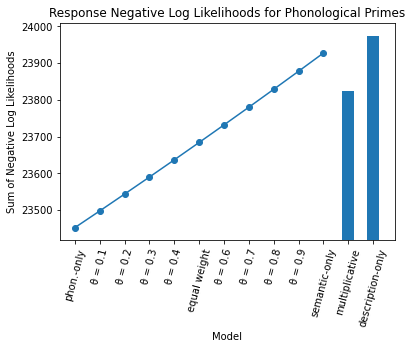

In [ ]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2] # models
y = phong['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for Phonological Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [ ]:
# calculate and sort BICs
delta(phong, len(phon)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,23452.741789,4.0,46936.911953,90.780640
0.1,23498.132109,4.0,47027.692593,91.718678
0.2,23543.991448,4.0,47119.411271,92.652932
0.3,23590.317914,4.0,47212.064203,93.583444
0.4,23637.109635,4.0,47305.647646,94.510254
0.5,23684.364762,4.0,47400.157900,95.433403
0.6,23732.081464,4.0,47495.591304,96.352930
0.7,23780.257929,4.0,47591.944234,80.259695
1.1,23824.316324,3.0,47672.203929,17.009177


## Semantic

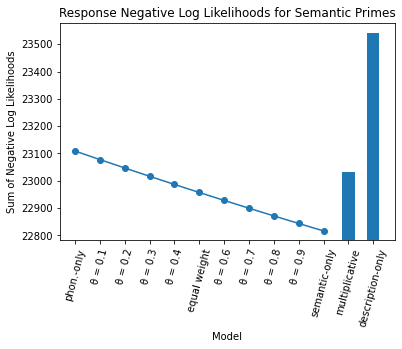

In [ ]:
y = semg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for Semantic Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [ ]:
delta(semg, len(sem)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
1.0,22816.252783,4.0,45663.857361,54.551406
0.9,22843.528486,4.0,45718.408767,55.424773
0.8,22871.240872,4.0,45773.833540,56.301218
0.7,22899.391481,4.0,45830.134758,57.180772
0.6,22927.981867,4.0,45887.315530,58.063467
0.5,22957.013600,4.0,45945.378996,58.949336
0.4,22986.488268,4.0,46004.328332,59.838414
0.3,23016.407475,4.0,46064.166746,20.398557
1.1,23030.525728,3.0,46084.565303,40.332176


## Both

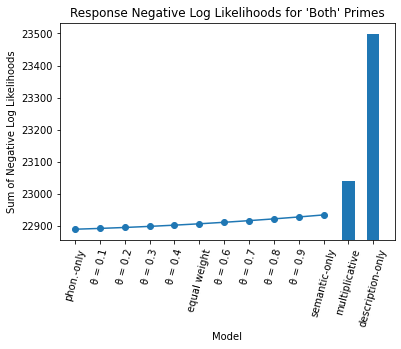

In [ ]:
y = bothg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for 'Both' Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [ ]:
delta(bothg, len(both)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,22889.779791,4.0,45810.901899,5.042916
0.1,22892.301249,4.0,45815.944816,5.912070
0.2,22895.257284,4.0,45821.856885,6.778264
0.3,22898.646416,4.0,45828.635149,7.641528
0.4,22902.467180,4.0,45836.276677,8.501889
0.5,22906.718124,4.0,45844.778566,9.359377
0.6,22911.397813,4.0,45854.137943,10.214018
0.7,22916.504822,4.0,45864.351961,11.065840
0.8,22922.037742,4.0,45875.417802,11.914870


## Neither

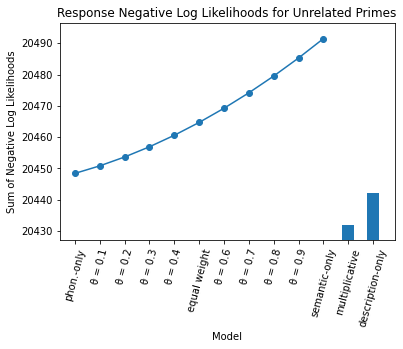

In [ ]:
y = neitherg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-5, max(y)+5)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for Unrelated Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [ ]:
delta(neitherg, len(neither)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
1.1,20431.992082,3.0,40887.074164,4.998183
1.2,20442.187840,1.0,40892.072347,35.544285
0.0,20448.414982,4.0,40927.616632,4.810410
0.1,20450.820187,4.0,40932.427042,5.665330
0.2,20453.652852,4.0,40938.092373,6.515965
0.3,20456.910835,4.0,40944.608338,7.362369
0.4,20460.592019,4.0,40951.970706,8.204594
0.5,20464.694316,4.0,40960.175300,9.042692
0.6,20469.215662,4.0,40969.217993,9.876713


# Correct and incorrect responses

In [ ]:
# merged dataframe
newd = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLLwithGroups.csv")

In [ ]:
# filter by correct and incorrect responses
incorrect = newd[newd['NewAccuracy']==0] # incorrect responses
correct = newd[newd['NewAccuracy']==1] # correct responses
print(len(incorrect))
print(len(correct))

71942
56095


In [ ]:
# group by model, sum negative log-likelihoods
incorrg = incorrect[['theta', 'NLL']].groupby(['theta']).sum()
corrg = correct[['theta', 'NLL']].groupby(['theta']).sum()

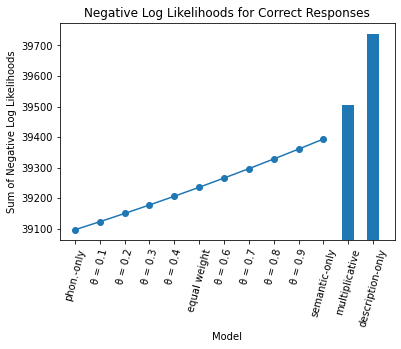

In [ ]:
# plot negative log-likelihoods for correct responses
y = corrg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11], y[:1.0] ,marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Correct Responses")
plt.xticks(x,values, rotation=75)
plt.show()

In [ ]:
# calculate and sort BICs
delta(corrg, len(correct)/13)

,NLL,k,deltaNLL,BIC,deltaBIC
theta,,,,,
0.0,39096.487004,4.0,26.289780,78226.453419,52.579561
0.1,39122.776785,4.0,27.057630,78279.032980,54.115259
0.2,39149.834414,4.0,27.822210,78333.148239,55.644420
0.3,39177.656624,4.0,28.583556,78388.792659,57.167112
0.4,39206.240180,4.0,29.341700,78445.959771,58.683399
0.5,39235.581880,4.0,30.096673,78504.643170,60.193347
0.6,39265.678553,4.0,30.848509,78564.836517,61.697018
0.7,39296.527062,4.0,31.597237,78626.533535,63.194474
0.8,39328.124299,4.0,32.342887,78689.728009,64.685774


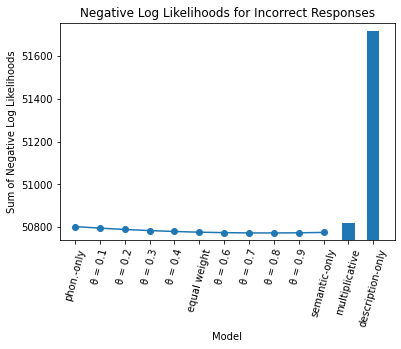

In [ ]:
# plot negative log-likelihoods for incorrect responses
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = incorrg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Incorrect Responses")
plt.xticks(x,values, rotation=75)
plt.show()

In [ ]:
# calculate and sort BICs
delta(incorrg, len(incorrect)/13)

,NLL,k,deltaNLL,BIC,deltaBIC
theta,,,,,
0.8,50773.554051,4.0,0.227138,101581.582766,0.454276
0.7,50773.781189,4.0,0.532012,101582.037042,1.064024
0.9,50774.313201,4.0,0.685052,101583.101066,1.370105
0.6,50774.998253,4.0,1.056787,101584.471171,2.113575
1.0,50776.055040,4.0,1.153883,101586.584746,2.307766
0.5,50777.208924,4.0,3.207999,101588.892512,6.415998
0.4,50780.416922,4.0,4.209093,101595.308509,8.418185
0.3,50784.626015,4.0,5.213996,101603.726695,10.427993
0.2,50789.840011,4.0,6.222755,101614.154688,12.445510


# Retrieval State

In [ ]:
# filter by response to question about cognitive state
know = newd[newd['Question.RESP'] == 1] # "I know the answer"
dontknow = newd[newd['Question.RESP'] == 2] # "I don't know the answer"
otherword = newd[newd['Question.RESP'] == 3] # "I have another word in mind that I don't think is correct"
tot = newd[newd['Question.RESP'] == 4] # "The correct answer is on the tip of my tongue"
print(len(know))
print(len(dontknow))
print(len(otherword))
print(len(tot))

89479
3354
27716
7488


In [ ]:
# group by model and sum negative log-likelihoods
knowg = know[['theta', 'NLL']].groupby(['theta']).sum()
dontknowg = dontknow[['theta', 'NLL']].groupby(['theta']).sum()
otherwordg = otherword[['theta', 'NLL']].groupby(['theta']).sum()
totg = tot[['theta', 'NLL']].groupby(['theta']).sum()

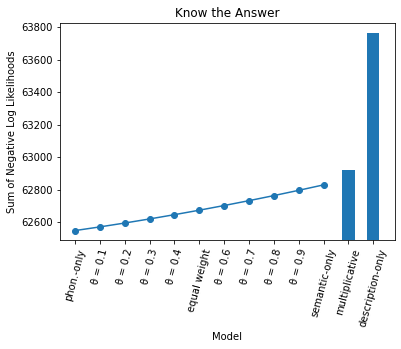

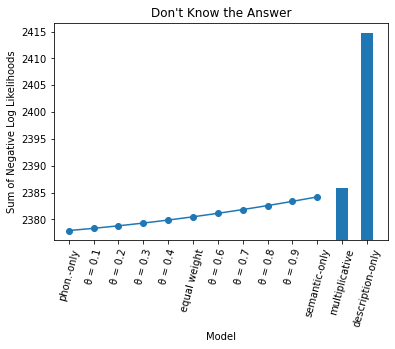

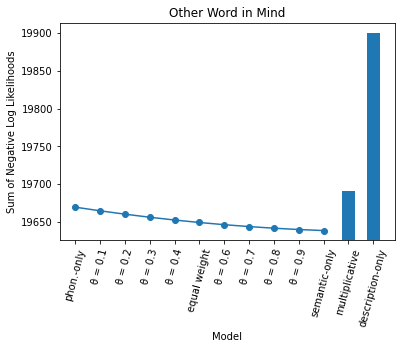

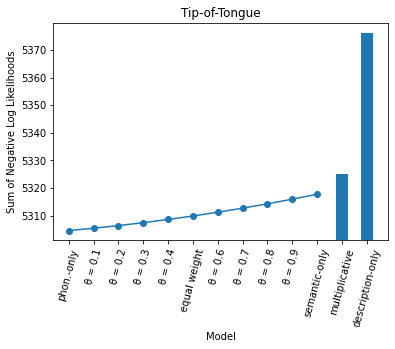

In [ ]:
# plots for each state
states = {"Know the Answer": knowg, "Don't Know the Answer": dontknowg, "Other Word in Mind": otherwordg, "Tip-of-Tongue": totg}
for state in states.keys():
  y = states[state]['NLL']
  k = (max(y) - min(y)) / 20
  plt.plot(x[:11],y[:1.0],marker="o")
  plt.bar(x[11:],y[1.1:], width=.05)
  plt.ylim(min(y)-k, max(y)+k)
  plt.xlabel("Model")
  plt.ylabel("Sum of Negative Log Likelihoods")
  plt.title(state)
  plt.xticks(x,values, rotation=75)
  plt.show()

In [ ]:
# results sorted from lowest (best) to highest
s1 = delta(knowg, len(know)/13)

In [ ]:
s1

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,62547.763107,2.0,125113.199833,62.943186
0.1,62570.397890,4.0,125176.143020,47.745116
0.2,62594.270448,4.0,125223.888136,50.210540
0.3,62619.375718,4.0,125274.098675,52.665949
0.4,62645.708693,4.0,125326.764625,55.111452
0.5,62673.264419,4.0,125381.876077,57.547155
0.6,62702.037996,4.0,125439.423232,59.973159
0.7,62732.024576,4.0,125499.396391,62.389566
0.8,62763.219358,4.0,125561.785956,64.796474


In [ ]:
# average BIC of additive models, repeated for each retrieval state
np.mean(s1['BIC'][0.1:0.9]) 

125389.99539355421

In [ ]:
s2 = delta(dontknowg, len(dontknow)/13)
s2.sort_values(by='theta',inplace=True)
np.mean(s2['BIC'][0.1:0.9]) 

4783.464134304614

In [ ]:
s3 = delta(otherwordg, len(otherword)/13)
s3.sort_values(by='theta',inplace=True)
np.mean(s3['BIC'][0.1:0.9])

39331.58536672732

In [ ]:
s4 = delta(totg, len(tot)/13)
s4.sort_values(by='theta',inplace=True)
np.mean(s4['BIC'][0.1:0.9])

10645.8619472925

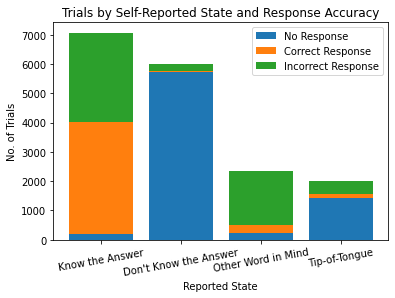

In [ ]:
# plot the proportion of trials in each state that were incorrect, correct or didn't respond 

st = states.keys()

# count the number of no-responses, correct, and incorrect responses for each state 
noresp = [len(julie_files[(julie_files['Resp'] == '12345')&(julie_files['Question.RESP'] == s)]) for s in range(1,5)]
corr = [len(julie_files[(julie_files['NewAccuracy'] == 1)&(julie_files['Question.RESP'] == s)]) for s in range(1,5)]
incorr = [len(julie_files[(julie_files['Resp'] != '12345')&(julie_files['NewAccuracy'] == 0)&(julie_files['Question.RESP'] == s)]) for s in range(1,5)]


# plot a bar for each state and corresponding number, set the bottom of each category to the height of the previous one
plt.bar(st, noresp)
plt.bar(st, corr, bottom = np.array(noresp))
plt.bar(st, incorr, bottom = np.array(noresp) + np.array(corr))


plt.xlabel("Reported State")
plt.xticks(rotation = 10)
plt.ylabel("No. of Trials")
plt.title('Trials by Self-Reported State and Response Accuracy')
plt.legend(["No Response", "Correct Response", "Incorrect Response"])

plt.show()


# By prime condition and retrieval state


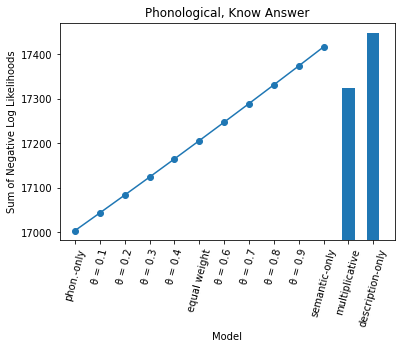

                NLL    k           BIC   deltaBIC
theta                                            
0.0    17003.983479  2.0  34023.050324  94.561920
0.1    17043.722756  4.0  34117.612244  80.161831
0.2    17083.803671  4.0  34197.774075  80.842324
0.3    17124.224833  4.0  34278.616399  81.520063
0.4    17164.984865  4.0  34360.136461  82.195078
0.5    17206.082404  4.0  34442.331539  82.867398
0.6    17247.516103  4.0  34525.198938  83.537051
0.7    17289.284628  4.0  34608.735989  60.888579
1.1    17323.499759  3.0  34669.624568  23.315486
0.8    17331.386661  4.0  34692.940054  84.868467
0.9    17373.820895  4.0  34777.808521  70.446917
1.0    17416.586036  2.0  34848.255439  55.591668
1.2    17448.152712  1.0  34903.847107   0.000000


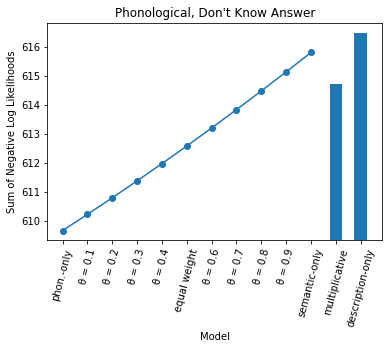

              NLL    k          BIC  deltaBIC
theta                                        
0.0    609.678835  2.0  1227.736979  9.423696
1.2    616.485510  1.0  1237.160676  0.070850
0.1    610.236453  4.0  1237.231526  1.140274
0.2    610.806591  4.0  1238.371800  1.165204
0.3    611.389193  4.0  1239.537004  0.466354
1.0    615.812024  2.0  1240.003358  0.723673
0.4    611.984206  4.0  1240.727031  1.214745
0.5    612.591578  4.0  1241.941776  0.059968
1.1    614.716390  3.0  1242.001744  1.179390
0.6    613.211258  4.0  1243.181134  1.263870
0.7    613.843193  4.0  1244.445004  1.288279
0.8    614.487332  4.0  1245.733283  1.312588
0.9    615.143626  4.0  1247.045871  0.000000


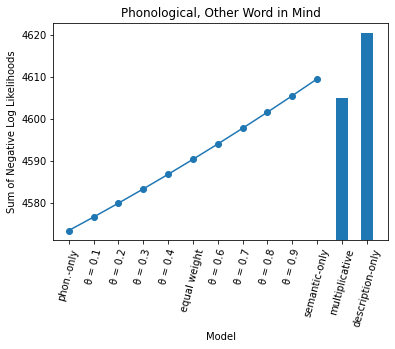

               NLL    k          BIC   deltaBIC
theta                                          
0.0    4573.431391  2.0  9159.271897  18.843494
0.1    4576.648580  4.0  9178.115391   6.613673
0.2    4579.955417  4.0  9184.729064   6.792270
0.3    4583.351552  4.0  9191.521335   6.970179
0.4    4586.836641  4.0  9198.491513   7.147406
0.5    4590.410344  4.0  9205.638919   7.323959
0.6    4594.072323  4.0  9212.962877   7.499845
0.7    4597.822246  4.0  9220.462723   7.675072
0.8    4601.659782  4.0  9228.137795   0.745457
1.1    4605.134789  3.0  9228.883252   2.718653
1.0    4609.596395  2.0  9231.601905   4.385538
0.9    4605.584606  4.0  9235.987443  11.336221
1.2    4620.559553  1.0  9247.323663   0.000000


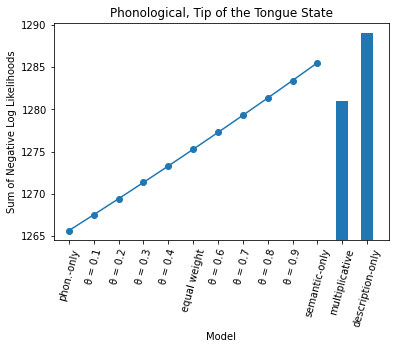

               NLL    k          BIC   deltaBIC
theta                                          
0.0    1265.648084  2.0  2541.150676  13.606978
0.1    1267.524320  4.0  2554.757654   3.802900
0.2    1269.425769  4.0  2558.560553   3.853134
0.3    1271.352336  4.0  2562.413687   3.903175
0.4    1273.303924  4.0  2566.316862   3.953026
0.5    1275.280437  4.0  2570.269888   4.002688
0.6    1277.281781  4.0  2574.272576   2.439955
1.1    1280.965385  3.0  2576.712531   1.612209
0.7    1279.307863  4.0  2578.324740   2.597003
1.0    1285.533618  2.0  2580.921742   1.504452
0.8    1281.358590  4.0  2582.426195   0.656417
1.2    1289.077679  1.0  2583.082611   3.494147
0.9    1283.433872  4.0  2586.576758   0.000000


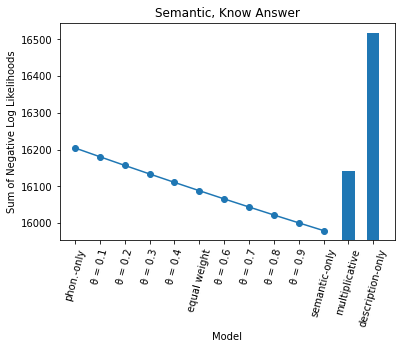

                NLL    k           BIC    deltaBIC
theta                                             
1.0    15980.113367  2.0  31975.197717   57.134290
0.9    16001.195021  4.0  32032.332008   42.771107
0.8    16022.580574  4.0  32075.103115   43.381081
0.7    16044.271115  4.0  32118.484196   43.993251
0.6    16066.267740  4.0  32162.477447   44.607637
0.5    16088.571559  4.0  32207.085084   45.224262
0.4    16111.183690  4.0  32252.309346   45.843149
0.3    16134.105264  4.0  32298.152495    7.736665
1.1    16141.716343  3.0  32305.889161   38.727655
0.2    16157.337425  4.0  32344.616816   47.087798
0.1    16180.881324  4.0  32391.704614   32.742624
0.0    16204.738127  2.0  32424.447238  618.452486
1.2    16517.707116  1.0  33042.899724    0.000000


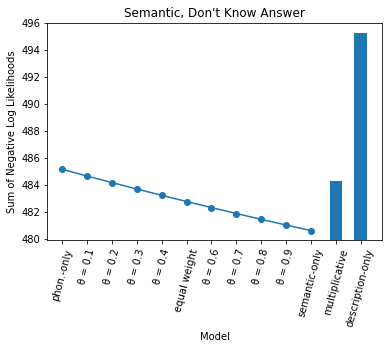

              NLL    k         BIC  deltaBIC
theta                                       
1.0    480.602302  2.0  969.145187  8.766762
0.9    481.015391  4.0  977.911949  0.320278
0.0    485.145822  2.0  978.232227  0.524048
0.8    481.437554  4.0  978.756275  0.862544
0.7    481.868826  4.0  979.618819  0.810611
1.1    484.259277  3.0  980.429430  0.070221
0.6    482.309242  4.0  980.499652  0.899194
0.5    482.758839  4.0  981.398845  0.917628
0.4    483.217653  4.0  982.316473  0.936135
0.3    483.685720  4.0  983.252608  0.954717
0.2    484.163079  4.0  984.207326  0.973375
0.1    484.649767  4.0  985.180701  9.346666
1.2    495.278538  1.0  994.527367  0.000000


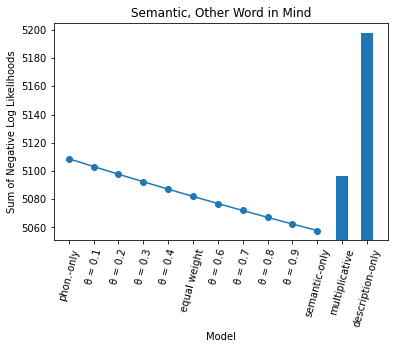

               NLL    k           BIC    deltaBIC
theta                                            
1.0    5057.742302  2.0  10128.129734   21.934095
0.9    5062.386784  4.0  10150.063830    9.486723
0.8    5067.130146  4.0  10159.550553    9.685144
0.7    5071.972718  4.0  10169.235697    9.884233
0.6    5076.914834  4.0  10179.119930   10.084000
0.5    5081.956835  4.0  10189.203930   10.284453
0.4    5087.099061  4.0  10199.488383   10.485599
0.3    5092.341860  4.0  10209.973982    2.030475
1.1    5096.518381  3.0  10212.004457    8.656971
0.2    5097.685584  4.0  10220.661428    9.338156
0.0    5108.677227  2.0  10229.999584    1.551849
0.1    5103.130586  4.0  10231.551433  170.440851
1.2    5197.834860  1.0  10401.992284    0.000000


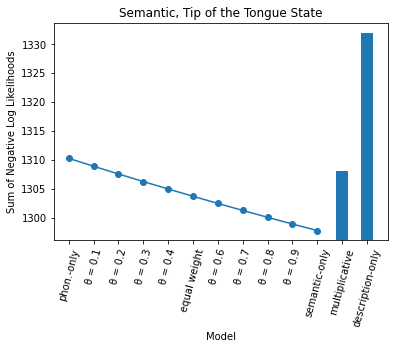

               NLL    k          BIC   deltaBIC
theta                                          
1.0    1297.794812  2.0  2605.515314  12.198645
0.9    1298.931290  4.0  2617.713959   2.322617
0.8    1300.092598  4.0  2620.036575   2.372449
0.7    1301.278823  4.0  2622.409025   2.422455
0.6    1302.490050  4.0  2624.831479   2.472635
0.5    1303.726368  4.0  2627.304115   2.522993
0.4    1304.987865  4.0  2629.827108   0.673479
0.0    1310.287449  2.0  2630.500587   0.451401
1.1    1308.031727  3.0  2630.951988   1.448650
0.3    1306.274630  4.0  2632.400639   2.624249
0.2    1307.586754  4.0  2635.024887   2.675151
0.1    1308.924330  4.0  2637.700038  31.239945
1.2    1331.988569  1.0  2668.939983   0.000000


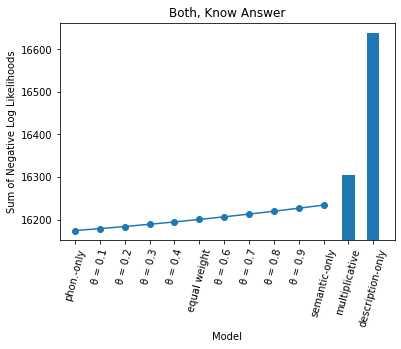

                NLL    k           BIC    deltaBIC
theta                                             
0.0    16173.987387  2.0  32362.960295   24.219352
0.1    16178.604303  4.0  32387.179647    9.849968
0.2    16183.529287  4.0  32397.029616   10.463896
0.3    16188.761235  4.0  32407.493511   11.075636
0.4    16194.299053  4.0  32418.569147   11.685207
0.5    16200.141657  4.0  32430.254354   12.292630
0.6    16206.287972  4.0  32442.546984   12.897923
0.7    16212.736933  4.0  32455.444908   13.501106
0.8    16219.487487  4.0  32468.946014   13.817894
1.0    16233.889194  2.0  32482.763908    0.284304
0.9    16226.538585  4.0  32483.048212  150.074746
1.1    16305.322339  3.0  32633.122958  651.809713
1.2    16638.719955  1.0  33284.932671    0.000000


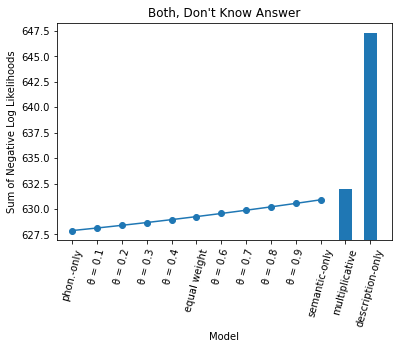

              NLL    k          BIC   deltaBIC
theta                                         
0.0    627.872514  2.0  1264.213240   6.054670
1.0    630.899849  2.0  1270.267910   2.917664
0.1    628.124574  4.0  1273.185574   0.526827
0.2    628.387988  4.0  1273.712401   0.549462
0.3    628.662719  4.0  1274.261864   0.572028
0.4    628.948733  4.0  1274.833891   0.594524
0.5    629.245995  4.0  1275.428416   0.616953
0.6    629.554471  4.0  1276.045369   0.494846
1.1    631.918947  3.0  1276.540214   0.144468
0.7    629.874128  4.0  1276.684682   0.661608
0.8    630.204932  4.0  1277.346290   0.683835
0.9    630.546850  4.0  1278.030125  20.847334
1.2    647.321676  1.0  1298.877459   0.000000


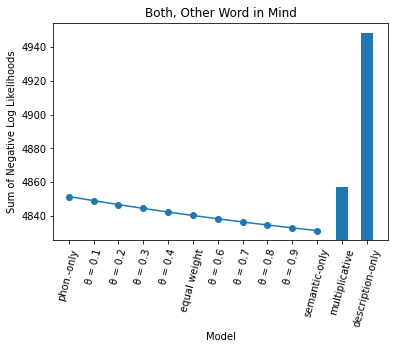

               NLL    k          BIC    deltaBIC
theta                                           
1.0    4831.410386  2.0  9675.366527   15.757919
0.9    4833.016469  4.0  9691.124446    3.392338
0.8    4834.712638  4.0  9694.516784    3.573008
0.7    4836.499142  4.0  9698.089792    3.754181
0.6    4838.376233  4.0  9701.843973    3.935862
0.5    4840.344164  4.0  9705.779836    4.118058
0.4    4842.403193  4.0  9709.897894    4.300774
0.3    4844.553580  4.0  9714.198668    1.458159
0.0    4851.555536  2.0  9715.656827    3.025857
0.2    4846.795588  4.0  9718.682684    4.667791
0.1    4849.129484  4.0  9723.350475   10.437012
1.1    4857.484428  3.0  9733.787488  169.309429
1.2    4948.412020  1.0  9903.096916    0.000000


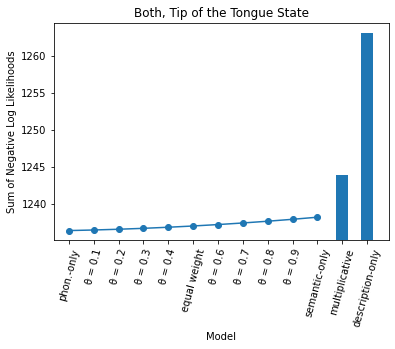

               NLL    k          BIC   deltaBIC
theta                                          
0.0    1236.364354  2.0  2482.539257   3.623923
1.0    1238.176315  2.0  2486.163180   6.343696
0.1    1236.442888  4.0  2492.506876   0.203066
0.2    1236.544421  4.0  2492.709942   0.248922
0.3    1236.668882  4.0  2492.958864   0.294638
0.4    1236.816201  4.0  2493.253502   0.340216
0.5    1236.986309  4.0  2493.593717   0.385657
0.6    1237.179137  4.0  2493.979374   0.430963
0.7    1237.394619  4.0  2494.410336   0.476135
0.8    1237.632686  4.0  2494.886471   0.521175
0.9    1237.893273  4.0  2495.407646   7.048463
1.1    1243.870142  3.0  2502.456109  28.798370
1.2    1263.174602  1.0  2531.254479   0.000000


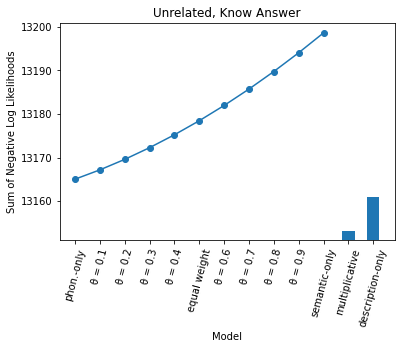

                NLL    k           BIC   deltaBIC
theta                                            
1.1    13153.255026  3.0  26328.287400   0.866704
1.2    13160.947494  1.0  26329.154105  15.472355
0.0    13165.054114  2.0  26344.626459  18.789020
0.1    13167.189508  4.0  26363.415480   4.821115
0.2    13169.600065  4.0  26368.236595   5.368640
0.3    13172.284385  4.0  26373.605235   5.913400
0.4    13175.241085  4.0  26379.518635   6.455430
0.5    13178.468800  4.0  26385.974065   6.994764
0.6    13181.966182  4.0  26392.968828   7.531435
0.7    13185.731899  4.0  26400.500263   8.065475
0.8    13189.764637  4.0  26408.565738   3.204472
1.0    13198.625989  2.0  26411.770210   5.392444
0.9    13194.063095  4.0  26417.162655   0.000000


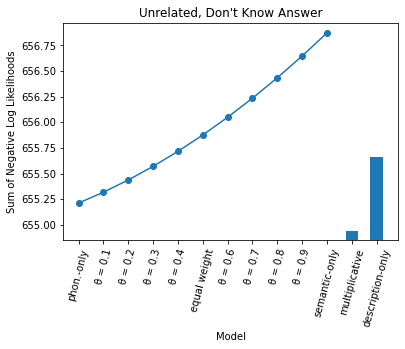

              NLL    k          BIC  deltaBIC
theta                                        
1.2    655.658728  1.0  1315.565951  3.355874
0.0    655.212417  2.0  1318.921825  3.318726
1.0    656.871780  2.0  1322.240551  0.393997
1.1    654.944531  3.0  1322.634549  4.996061
0.1    655.318314  4.0  1327.630609  0.238835
0.2    655.437732  4.0  1327.869444  0.265740
0.3    655.570602  4.0  1328.135184  0.292509
0.4    655.716856  4.0  1328.427693  0.319145
0.5    655.876429  4.0  1328.746839  0.345650
0.6    656.049254  4.0  1329.092489  0.372023
0.7    656.235266  4.0  1329.464512  0.398268
0.8    656.434400  4.0  1329.862780  0.424385
0.9    656.646592  4.0  1330.287166  0.000000


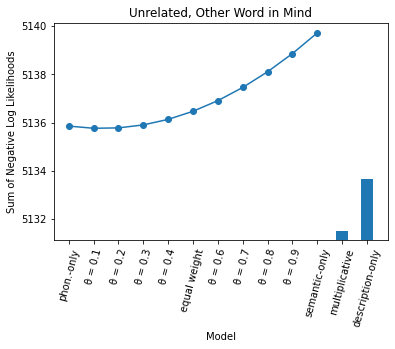

               NLL    k           BIC  deltaBIC
theta                                          
1.2    5133.650079  1.0  10273.610076  8.355623
1.1    5131.517972  3.0  10281.965699  2.361634
0.0    5135.853748  2.0  10284.327332  7.732413
1.0    5139.719954  2.0  10292.059745  4.704980
0.1    5135.762526  4.0  10296.764725  0.032673
0.2    5135.778862  4.0  10296.797398  0.246740
0.3    5135.902232  4.0  10297.044138  0.459770
0.4    5136.132117  4.0  10297.503907  0.671775
0.5    5136.468004  4.0  10298.175682  0.882767
0.6    5136.909388  4.0  10299.058448  1.092758
0.7    5137.455767  4.0  10300.151206  1.301759
0.8    5138.106646  4.0  10301.452965  1.509781
0.9    5138.861537  4.0  10302.962746  0.000000


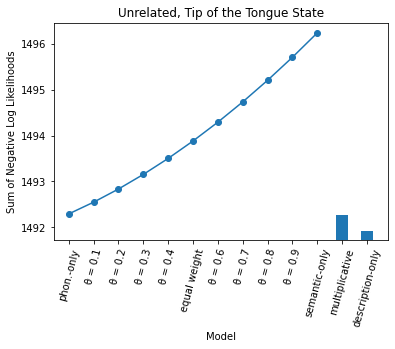

               NLL    k          BIC  deltaBIC
theta                                         
1.2    1491.931539  1.0  2988.938252  5.801501
0.0    1492.294703  2.0  2994.739753  5.034872
1.1    1492.274552  3.0  2999.774626  2.842506
1.0    1496.233392  2.0  3002.617132  2.783242
0.1    1492.549839  4.0  3005.400374  0.572707
0.2    1492.836193  4.0  3005.973082  0.634845
0.3    1493.153616  4.0  3006.607927  0.696690
0.4    1493.501961  4.0  3007.304616  0.758244
0.5    1493.881083  4.0  3008.062860  0.819512
0.6    1494.290839  4.0  3008.882373  0.880497
0.7    1494.731087  4.0  3009.762870  0.941201
0.8    1495.201688  4.0  3010.704071  1.001628
0.9    1495.702502  4.0  3011.705699  0.000000


In [ ]:
# plots for each prime condition and state
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 
pc = {'P': 'Phonological', 'R': 'Semantic', 'B': 'Both', 'U': 'Unrelated'}
states = ["Know Answer", "Don't Know Answer", "Other Word in Mind", "Tip of the Tongue State"]
for p in ['P', 'R', 'B', 'U']:
  for i in range(1,5):
    subset = newd[(newd['PrimeCondition'] == p) & (newd['Question.RESP'] == i)]
    grouped = subset[['theta', 'NLL']].groupby(['theta']).sum()
    y = grouped['NLL']
    k = (max(y) - min(y)) / 20
    plt.plot(x[:11],y[:1.0],marker="o")
    plt.bar(x[11:],y[1.1:], width=.05)
    plt.ylim(min(y)-k, max(y)+k)
    plt.xlabel("Model")
    plt.ylabel("Sum of Negative Log Likelihoods")
    plt.title(pc[p] + ", "+ states[i-1])
    plt.xticks(x,values, rotation=75)
    plt.show()
    print(delta(grouped, len(subset)/13))